In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 09:36:15.486: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:1124): Gtk-CRITICAL **: 09:36:16.283: gtk_window_resize: assertion 'height > 0' failed


In [3]:
import subprocess
dataset_id = 'ds000171'
subject_id = 'control01'

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)

# Download one subject's data from each dataset
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join('sub-{}'.format(subject_id), '*'),# We are asking to get all files within the subject_dir/anat folder by using the wildcard *
               ], check=False)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 436 entities [00:30, 14.39 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   1%|          | 83.6k/8.77M [00:00<00:18, 491kB/s]
sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]
                                                                                    
sub-control01_T1w.nii.gz:   3%|▎         | 305k/8.77M [00:00<00:09, 945kB/s] 0<?, ?B/s]

sub-control01_T1w.nii.gz:   8%|▊         | 748k/8.77M [00:00<00:04, 2.09MB/s]0<?, ?B/s]


sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]



sub-control01_task-music_run-3_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]



                                                                                    
sub-control01_T1w.nii.gz:  18%|█▊        | 1.61M/8.77M [00:00<00:01, 4.33MB/s]0<01:17, 460kB/s]

sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 83.6k/33.9M [00:00<01:15, 468kB/s]
sub-control01_task-music_run-1_bold.nii.gz:   1%|          | 237k/33.8M [00:00<00:37, 939kB/s] 


sub-control01_T1w.

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 






sub-control01_task-nonmusic_run-5_bold.nii.gz: 100%|█████████▉| 33.8M/33.9M [00:14<00:00, 9.55MB/s]



                                                                                                   

CompletedProcess(args=['openneuro-py', 'download', '--dataset', 'ds000171', '--target-dir', '/home/jovyan/Data/dataset/ds000171', '--include', 'sub-control01/*'], returncode=0)

In [7]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [8]:
print(bids_root)

/home/jovyan/Data/dataset/ds000171


In [4]:
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

data=get_json_from_file(op.join(bids_root,'dataset_description.json'))
data

{'Name': 'Neural Processing of Emotional Musical and Nonmusical Stimuli in Depression',
 'BIDSVersion': '1.0.0-rc2',
 'License': 'PDDL',
 'Authors': ['Rebecca J. Lepping',
  'Ruth Ann Atchley',
  'Evangelia Chrysikou',
  'Laura E. Martin',
  'Alicia A. Clair',
  'Rick E. Ingram',
  'W. Kyle Simmons',
  'Cary R. Savage'],
 'Acknowledgements': 'The authors wish to acknowledge Trisha Patrician and Natalie Stroupe for their assistance with screening of participants, and Allan Schmitt and Franklin Hunsinger for their role in collecting the MR data.',
 'HowToAcknowledge': 'Please cite the papers listed in the ReferencesAndLinks',
 'Funding': 'This work was supported by funding to RL from The Society for Education, Music and Psychology Research (SEMPRE: Arnold Bentley New Initiatives Fund), and the University of Kansas Doctoral Student Research Fund. MR imaging was provided by pilot funding from the Hoglund Brain Imaging Center. The Hoglund Brain Imaging Center is supported by a generous gift

## 1.1.1 fMRI Voxel Standardization

### Old

In [9]:
mkdir_no_exist(op.join(preproc_root, "sub-{}".format(subject_id), "func"))

# Run the standarization for each task run
for r in range(1, 4):
    # Compute the mean of the fMRI data
    subprocess.run(["bet", op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r)),
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}.nii.gz".format(subject_id, r)), '-m'
    ], check=True)

    subprocess.run(["fslmaths", op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r)),
                    '-mas', op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_mask.nii.gz".format(subject_id, r)),
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r))
    ], check=True)
    
    subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r)), "-mean", 
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_mean.nii.gz".format(subject_id, r))        
        
    ], check=True)

    # Computer the std of the fMRI data     
    subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r)), "-std",
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_std.nii.gz".format(subject_id, r))        
        
    ], check=True)

    # # Correct the zero values in the std
    # subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_std.nii.gz".format(subject_id, r)),
    #                 "-add", "0.001",
    #                 op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_stdfix.nii.gz".format(subject_id, r))
        
    # ], check=True)

    # Standardize data (X - mean / std)                  
    subprocess.run(["fslmaths", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_masked.nii.gz".format(subject_id, r)), "-sub",
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_mean.nii.gz".format(subject_id, r)), "-div",
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_std.nii.gz".format(subject_id, r)),
                    op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_standardized.nii.gz".format(subject_id, r))
        
    ], check=True)


 Error in command line: unknown option "-mean"


Usage: fslmaths [-dt <datatype>] <first_input> [operations and inputs] <output> [-odt <datatype>]

Datatype information:
 -dt sets the datatype used internally for calculations (default float for all except double images)
 -odt sets the output datatype ( default is float )
 Possible datatypes are: char short int float double input
 "input" will set the datatype to that of the original image

Binary operations:
  (some inputs can be either an image or a number)
 -add   : add following input to current image
 -sub   : subtract following input from current image
 -mul   : multiply current image by following input
 -div   : divide current image by following input
 -rem   : modulus remainder - divide current image by following input and take remainder
 -mas   : use (following image>0) to mask current image
 -thr   : threshold below the following number (zero anything below the number)
 -thrp  : threshold below the following percentage (0-100

CalledProcessError: Command '['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_masked.nii.gz', '-mean', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_mean.nii.gz']' returned non-zero exit status 1.

### New: through fslmaths inm (intensity normalization (through 3d mean))

In [ ]:
mkdir_no_exist(op.join(preproc_root, "sub-{}".format(subject_id), "func"))

for r in range(1,4):
    functional_path=op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r))
    stripped_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_stripped.nii.gz".format(subject_id,r))
    standardized_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, r))
    
    # skull stripping with BET
    subprocess.run(["bet", functional_path,
                stripped_path, "-m", "-F",
    ], check=True)
    
    # Standardize so that the mean becomes 100
    subprocess.run(["fslmaths", stripped_path,
                    "-inm", "100", standardized_path,
    ], check=True)

print("done")

### Final: normalization through numpy

In [5]:
mkdir_no_exist(op.join(preproc_root, "sub-{}".format(subject_id), "func"))

for r in range(1,4):
    functional_path=op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r))
    stripped_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_stripped.nii.gz".format(subject_id,r))
    standardized_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, r))
    
    # skull stripping with BET
    subprocess.run(["bet", functional_path,
                stripped_path, "-m", "-F",
    ], check=True)
    
    # Standardize
    img = nib.load(stripped_path)

    # Convert Nifti img to numpy array
    img_array = np.array(img.dataobj)

    # Calculate Z-score using mean and std
    inm_img = nib.Nifti1Image(((img_array - np.mean(img_array, keepdims=True)) / np.std(img_array, keepdims=True)), img.affine, img.header)
    
    # Save as a Nifti file
    nib.save(inm_img, standardized_path)

print("done")

done


In [ ]:
mkdir_no_exist(op.join(preproc_root, "sub-{}".format(subject_id), "func"))

for r in range(1,4):
    functional_path=op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, r))
    stripped_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_stripped.nii.gz".format(subject_id,r))
    standardized_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, r))
    
    # skull stripping with BET
    subprocess.run(["bet", functional_path,
                stripped_path, "-m", "-F",
    ], check=True)
    
    # Standardize
    img = nib.load(stripped_path)

    # Convert Nifti img to numpy array
    img_array = np.array(img.dataobj)

    # Calculate Z-score using mean and std
    inm_img = nib.Nifti1Image(((img_array - np.mean(img_array, keepdims=True)) / np.std(img_array, keepdims=True)), img.affine, img.header)
    
    # Save as a Nifti file
    nib.save(inm_img, standardized_path)

print("done")

In [ ]:
# Displaying the original, skull stripped and normalized volumes for run O1 of subject O1

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, 1))) # original functional data
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_stripped.nii.gz".format(subject_id,1))) # skull stripped functional data
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, 1))) # skull stripped and nomralized data


In [6]:
# Concatenation of the first 3 task-music runs of subject control01 (skull-stripped and normalized)

fmri_files = []

for r in range(1, 4):
    normalized_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_inm.nii.gz".format(subject_id, r))
    fmri_files.append(normalized_path)

concat_img = nilearn.image.concat_imgs(fmri_files)
concat_img.to_filename(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)))

In [85]:
# Display the concatenated first 3 runs

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)))
# fsleyesDisplay.load(op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_bold.nii.gz".format(subject_id, 1)))


(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.560: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.560: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.560: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.560: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.561: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.561: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.561: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:59:52.561: file ../gio/gfileinfo.

In [14]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ func/
|--------------- sub-control01_task-music_run-1.nii.gz
|--------------- sub-control01_task-music_run-1_inm.nii.gz
|--------------- sub-control01_task-music_run-1_mask.nii.gz
|--------------- sub-control01_task-music_run-1_masked.nii.gz
|--------------- sub-control01_task-music_run-1_stripped.nii.gz
|--------------- sub-control01_task-music_run-1_stripped_mask.nii.gz
|--------------- sub-control01_task-music_run-2_inm.nii.gz
|--------------- sub-control01_task-music_run-2_stripped.nii.gz
|--------------- sub-control01_task-music_run-2_stripped_mask.nii.gz
|--------------- sub-control01_task-music_run-3_inm.nii.gz
|--------------- sub-control01_task-music_run-3_stripped.nii.gz
|--------------- sub-control01_task-music_run-3_stripped_mask.nii.gz
|--------------- sub-control01_task-music_run_stripped.nii.gz
|--- s

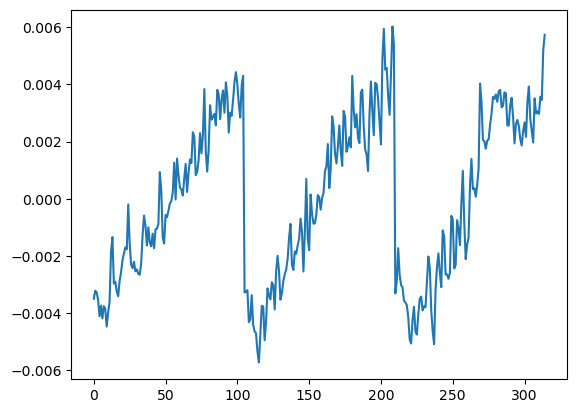


(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 11:03:52.753: file ../gio/gfileinfo.

In [88]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id))).get_fdata().mean(axis=(0,1,2)))


## 1.1.2 Old: Skull Stripping, Motion Correction, and Smoothing

In [16]:
# subprocess.run(["bet", op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_concat.nii.gz".format(subject_id)),
#                 op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)), "-m", "-F",
    
# ], check=True)

#### TODO: Perform manual correction on skull stripping

In [17]:
# fsleyesDisplay.resetOverlays()
# fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)))
# fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped_mask.nii.gz".format(subject_id)))


In [8]:
mcflirt(infile=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)), o=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)), plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [59]:
# Displaying the concatenated 3 runs before and after motion correction

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_stripped.nii.gz".format(subject_id)))
fsleyesDisplay.load(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)))

In [9]:
# nilearn.image.smooth_img(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id)),6)

# Applying smoothing with FWHM = 4
non_smoothed_path=op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id))
smoothed_path='{}_smoothed-6mm.nii.gz'.format(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco".format(subject_id)))
subprocess.run(['fslmaths',non_smoothed_path, '-s', str(4/2.3548), smoothed_path])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_moco.nii.gz', '-s', '1.6986580601324954', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_moco_smoothed-6mm.nii.gz'], returncode=0)

In [61]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('{}_smoothed-6mm'.format(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco".format(subject_id))))

In [10]:
file = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco_smoothed-6mm.nii.gz".format(subject_id))
img = nib.load(file)
a = np.array(img)
print(a)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (80, 80, 50, 315)
affine:
[[-2.89823341e+00  0.00000000e+00  1.04698524e-01  1.18931046e+02]
 [-6.50556833e-02  2.22152901e+00 -1.92718816e+00 -7.74534302e+01]
 [ 7.75302127e-02  1.86408401e+00  2.29673338e+00 -1.40277512e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  80  80  50 315   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.   2.9  2.9  3.   3.   1.   1.   1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min      

## 1.2 Design matrix

In [11]:
# Extracting the events from the 1st run of music task of subject control01

events_1=pd.read_table(op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_events.tsv".format(subject_id, 1)))
events_1

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [12]:
# Extracting the events from the 2nd run of music task of subject control01

events_2=pd.read_table(op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_events.tsv".format(subject_id, 2)))
events_2

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,positive_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,negative_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [13]:
# Concatenating the events of the 1st 3 runs of music task of subject control01 into a single df

events_dfs=[]
for r in range(1,4):
    events_df_r=pd.read_table(op.join(bids_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run-{}_events.tsv".format(subject_id, r)))
    events_df_r['onset']=events_df_r['onset']+(r-1)*312 # increasing the onsets of runs 02 and 03 to be continuation of the time of run 01
    events_dfs.append(events_df_r)
events_tot=pd.concat(events_dfs).reset_index(drop=True)
events_tot

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [14]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
# running a GLM to the fixed parameters


# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3, # from the task-music_bold.json file on the openneuro database
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           high_pass=.005)

# Fit the model to our design and data

##Check this is correct
fmri_glm = fmri_glm.fit(op.join('{}_smoothed-6mm.nii.gz'.format(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco".format(subject_id)))), events_tot)
## 

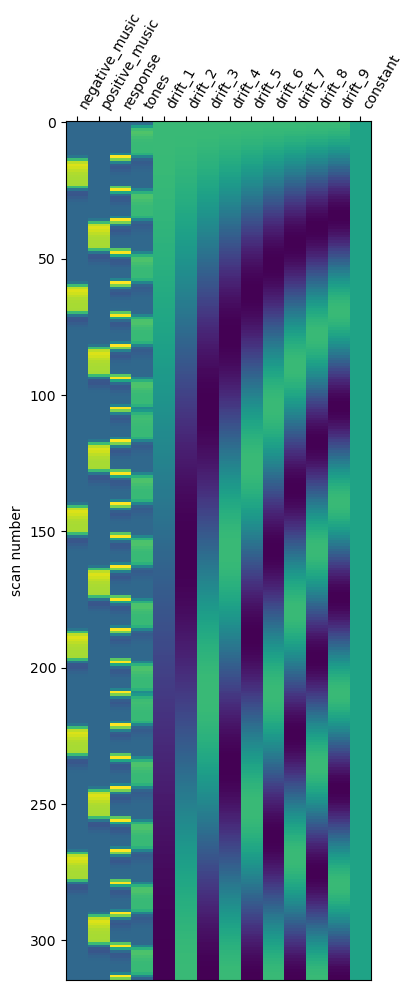

In [16]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

## Part 1.3 Beta Maps

In [17]:
# Isolating negative_music in contrast map

#negative_music_regressor = np.array(

df = fmri_glm.design_matrices_[0]
contrast_vectors = {}

# Loop through each column in the DataFrame
for column_index, column_name in enumerate(df.columns):
    # Create a contrast vector with zeros
    contrast_vector = np.zeros(df.shape[1])
    
    # Set the value at the specified index to 1
    contrast_vector[column_index] = 1
    
    # Store the contrast vector in the dictionary with the column name as the key
    contrast_vectors[column_name] = contrast_vector

# Print the contrast vectors for each column
for name, vector in contrast_vectors.items():
    print(f"Contrast Vector for '{name}': {vector}")

Contrast Vector for 'negative_music': [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'positive_music': [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'response': [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'tones': [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'drift_1': [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'drift_2': [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'drift_3': [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'drift_4': [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Contrast Vector for 'drift_5': [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Contrast Vector for 'drift_6': [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Contrast Vector for 'drift_7': [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Contrast Vector for 'drift_8': [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Contrast Vector for 'drift_9': [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Contrast Vec

#### negative_music beta map

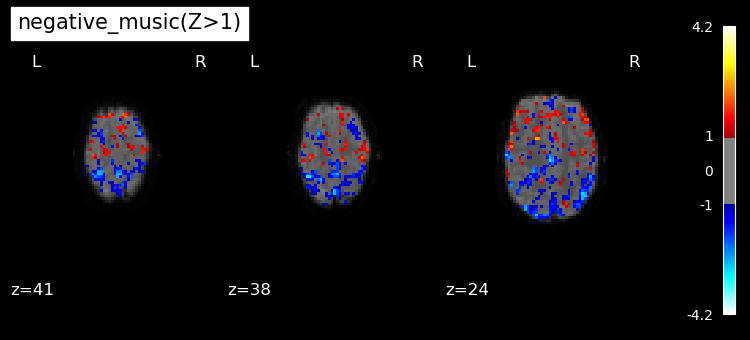

In [18]:
# Obtain z-score map
import nibabel as nib
regressor_of_interest = 'negative_music'
file_name = ''.join(['z_map_', regressor_of_interest, '_uncorrected.nii.gz'])

z_map = fmri_glm.compute_contrast(contrast_vectors[regressor_of_interest],
                                  output_type='z_score')
nib.save(z_map, file_name)

## Visualize beta map
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
threshold_val = 1

plot_title = ''.join([regressor_of_interest, '(Z>', str(threshold_val),')'])
fmri_img = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco.nii.gz".format(subject_id))
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold_val,
              display_mode='z', cut_coords=[41,38,24], black_bg=True,
              title=plot_title)
plt.show()

In [34]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load('{}_smoothed-6mm'.format(op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco".format(subject_id))))

### positive_music beta map

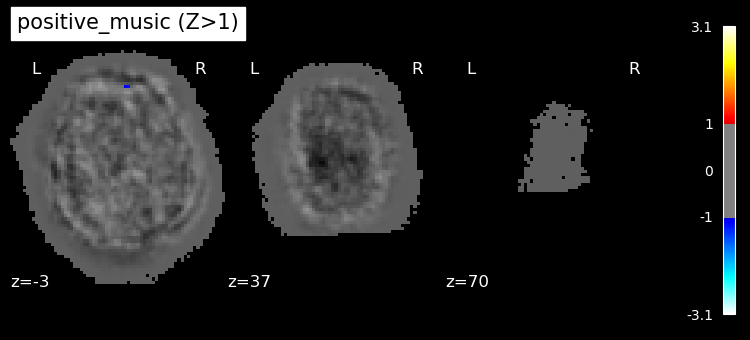

In [38]:
# Obtain z-score map
import nibabel as nib
regressor_of_interest = 'positive_music'
file_name = ''.join(['z_map_', regressor_of_interest, '_uncorrected.nii.gz'])

z_map = fmri_glm.compute_contrast(contrast_vectors[regressor_of_interest],
                                  output_type='z_score')
nib.save(z_map, file_name)

## Visualize beta map
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
threshold_val = 1

plot_title = ''.join([regressor_of_interest, ' (Z>', str(threshold_val),')'])

## Check this is correct ##
fmri_img = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco_smoothed-6mm.nii.gz".format(subject_id))
##
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold_val,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title=plot_title)
plt.show()

### positive_music minus negative_music beta map

[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


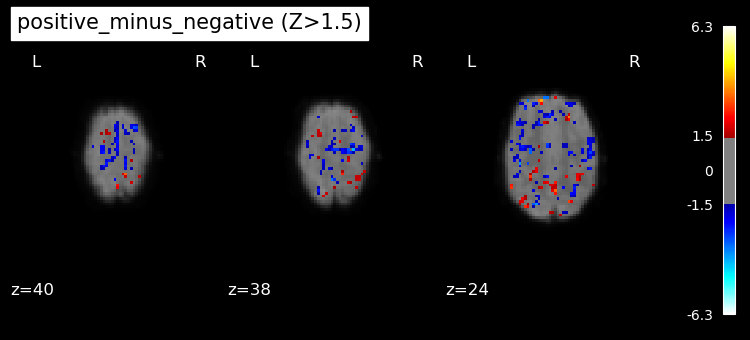

In [22]:
positive_minus_negative = contrast_vectors['positive_music']-contrast_vectors['negative_music']
print(positive_minus_negative)

# Obtain z-score map
import nibabel as nib
regressor_of_interest = 'positive_minus_negative'
file_name = ''.join(['z_map_', regressor_of_interest, '_uncorrected.nii.gz'])

z_map = fmri_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')
nib.save(z_map, file_name)

## Visualize beta map
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
threshold_val = 1.5

plot_title = ''.join([regressor_of_interest, ' (Z>', str(threshold_val),')'])
#file = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco_smoothed-6mm.nii.gz".format(subject_id))
#fmr_img = nib.load(file)
fmri_img = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco_smoothed-6mm.nii.gz".format(subject_id))
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold_val,
              display_mode='z', cut_coords=[40,38,24], black_bg=True,
              title=plot_title)
plt.show()

## 1.4 AAL Atlas Parcellation

In [40]:
# To display z_map in FSLeyes
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(''.join(['z_map_', regressor_of_interest, '_uncorrected.nii.gz']))

In [93]:
# Download AAL Atlas
from nilearn.datasets import fetch_atlas_aal
atlas = fetch_atlas_aal()
atlas_img = atlas.maps

resampled_atlas = nilearn.image.resample_to_img(atlas_img, fmri_img, interpolation='nearest')
resampled_atlas.to_filename('resampled_aal_atlas.nii.gz')

# Display atlas in FSLeyes
fsleyesDisplay.load('resampled_aal_atlas.nii.gz')

In [95]:
# Download AAL Atlas
from nilearn.datasets import fetch_atlas_aal
from nilearn.input_data import NiftiLabelsMasker
atlas = fetch_atlas_aal()
atlas_img = atlas.maps

masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False, detrend=True)

time_series = masker.fit_transform(fmri_img)
img_4d = masker.inverse_transform(time_series)

img_4d.to_filename('resampled_aal_atlas.nii.gz')

# Display atlas in FSLeyes
fsleyesDisplay.load('resampled_aal_atlas.nii.gz')

# PCA

In [68]:
file = op.join(preproc_root, "sub-{}".format(subject_id), "func", "sub-{}_task-music_run_moco_smoothed-6mm.nii.gz".format(subject_id))
img = nib.load(file)
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape

(80, 80, 50, 315)

In [69]:
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
print (vol_shape, n_vols)

(80, 80, 50) 315


In [70]:
slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 
samples = data[slice_non_background]

In [71]:
spatial_means = np.mean(samples, axis=1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.outer(spatial_means, np.ones(n_vols))
# Subtract the means for each row, put the result into X
X = samples - row_means
# Verify that the spatial mean behaves as expected after substraction
#assert np.abs(X.mean(axis=-1)).max() < 1e-10

In [ ]:
X.shape

In [84]:
from sklearn.decomposition import PCA
nb_components = 10

pca = PCA(n_components=nb_components)
pca.fit(X.T)

PCA(n_components=10)


(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:1124): GLib-GIO-CRITICAL **: 10:57:52.179: file ../gio/gfileinfo.

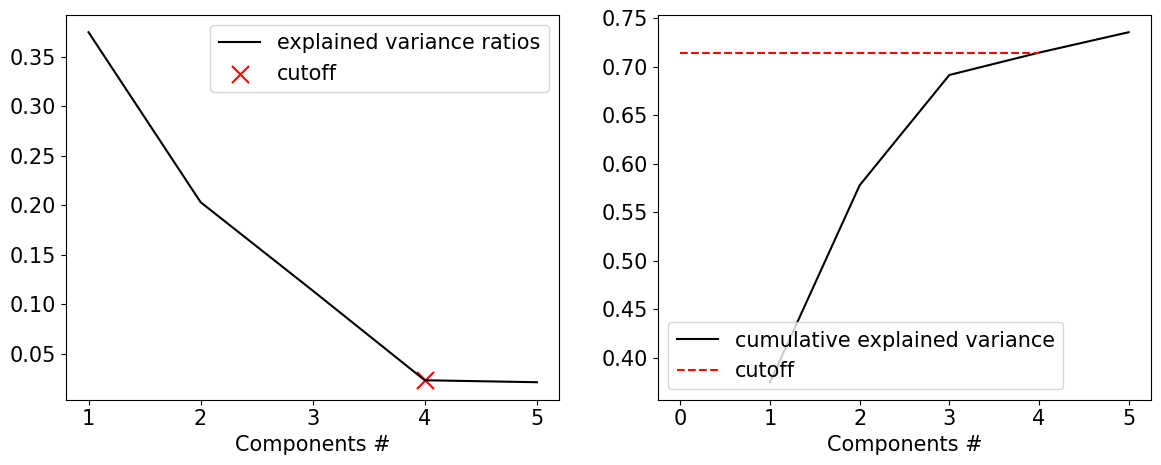

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 4

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

In [82]:
pca_clusters = [] # List of spatial components (you should have in the list elements of the shape 30)
for cluster_idx in range(nb_clusters):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx]
    pca_clusters.append(pca_component)

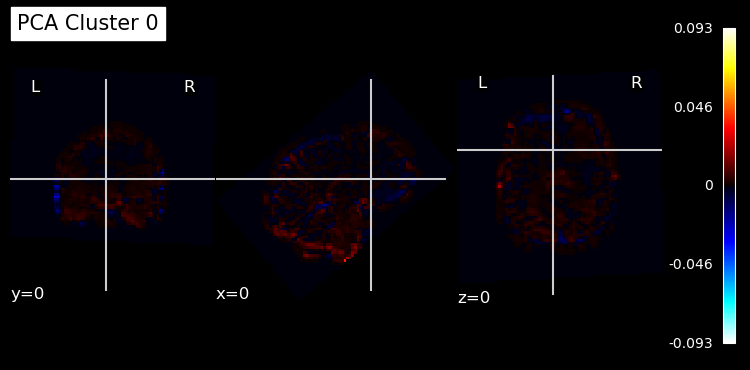

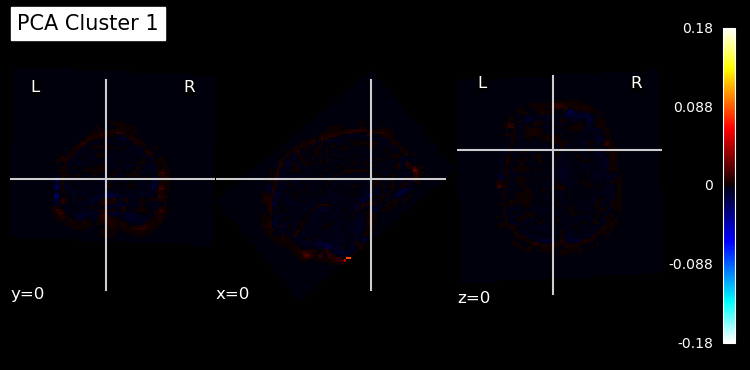

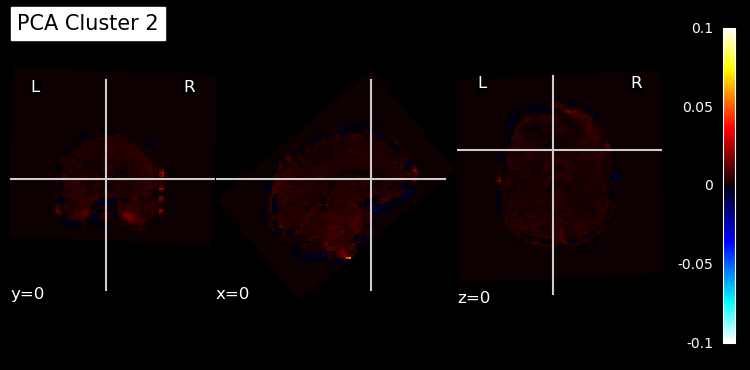

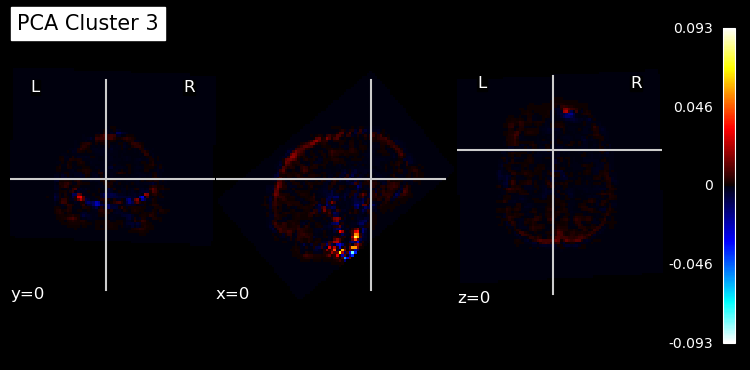

In [83]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
visual_idx = [0,1,2,3] 
for index in visual_idx : 
    plot_stat_map(nib.Nifti1Image(pca_clusters[index], affine), bg_img=mean_img_, threshold=0,
                   cut_coords=[0,0,0], black_bg=True,
                  title=f'PCA Cluster {index}')
    
plt.show()